<a href="https://colab.research.google.com/github/jun1116/CodeStates_Section_Project/blob/master/ai_sc21x_%E1%84%8C%E1%85%A1%E1%86%BC%E1%84%92%E1%85%A7%E1%86%BC%E1%84%8C%E1%85%AE%E1%86%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SC21x
 
## 선형모델 (Linear Models)

In [ ]:
# Google Colab에서 하시는 경우 해당 셀을 먼저 실행해주시기 바랍니다.
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install plotly==4.*

     |████████████████████████████████| 81kB 4.4MB/s 
     |████████████████████████████████| 245kB 11.3MB/s 
     |████████████████████████████████| 3.1MB 20.5MB/s 
     |████████████████████████████████| 604kB 64.0MB/s 
     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 296kB 39.4MB/s 
  Created wheel for phik: filename=phik-0.11.0-cp36-none-any.whl size=599738 sha256=9e4dbd90fad454caebf022081f0581b28465c6cf7cfc80692f9af97e944fe483
  Stored in directory: /root/.cache/pip/wheels/af/54/11/aba77f21075918de02f7964eabfe8c10d5542df9e6ad10b225
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=66f0eb04281a48c96fb1ae7e95ab8829d22337c2912462d40073072a9dff7e80
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built phik htmlmin
ERROR: goog

# Part 1 - 분류 (Classification): 헌혈 여부 예측하기 🚑
Part 1에선 대만의 이동식 헌혈 차량 헌혈자들의 정보를 담은 데이터셋을 다룹니다. 대만의 수혈 서비스 센터 (The Blood Transfusion Service Center)는 이동식 차량으로 대학교들을 돌면서 헌혈 행사를 진행, 수혈을 위한 혈액을 기부 받습니다.

Part 1의 목표는 각 헌혈자의 정보를 활용해서 **헌혈자가 2007년 3월에 헌혈을 했는지 여부**를 예측하는 것입니다. 

헌혈 여부 및 공급 요구를 추적하고 예측하는 좋은 데이터 기반 시스템은 공급망 전체를 개선하여 더 많은 환자가 필요한 수혈을 받도록 할 수 있습니다.

In [ ]:

from matplotlib import rc
import matplotlib.font_manager as fm
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
# rc('font', family='AppleGothic')


In [ ]:
# 분석에 필요한 라이브러리 및 데이터셋을 불러옵니다
import pandas as pd

donors = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')
assert donors.shape == (748,5)  # 데이터셋이 잘 불러와졌는지 assert를 사용해 검증합니다.

# 칼럼의 이름을 이해하기 쉽도록 변경합니다.
donors = donors.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

In [ ]:
donors.head()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


## 칼럼 설명:
- **months_since_last_donation**: 마지막으로 헌혈을 한 후에 지난 개월수
- **number_of_donations**: 헌혈 횟수
- **total_volume_donated**: 기부한 혈액 총량
- **months_since_first_donation**: 첫 헌혈을 한 후에 지난 개월수
- **made_donation_in_march_2007**: 2007년 헌혈을 했는지 여부 (target)

데이터를 본다면 약 3/4에 해당하는 과반수가 2007년 3월에 헌혈을 하지 않았다는 것을 알 수 있습니다.  
아래는 Baseline 모델의 정확도 점수 (accuracy score)를 나타낸 것입니다.

In [ ]:
donors['made_donation_in_march_2007'].value_counts(normalize=True)

0    0.762032
1    0.237968
Name: made_donation_in_march_2007, dtype: float64

In [ ]:
donors.info()
donors['made_donation_in_march_2007'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   months_since_last_donation   748 non-null    int64
 1   number_of_donations          748 non-null    int64
 2   total_volume_donated         748 non-null    int64
 3   months_since_first_donation  748 non-null    int64
 4   made_donation_in_march_2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


0    570
1    178
Name: made_donation_in_march_2007, dtype: int64

<AxesSubplot:xlabel='made_donation_in_march_2007', ylabel='count'>

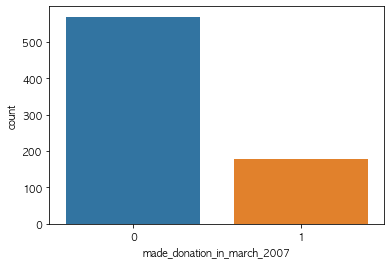

In [ ]:
# donors.plot(kind='bar',x='number_of_donations',y='total_volume_donated')
sns.countplot(x = donors['made_donation_in_march_2007'])

<AxesSubplot:>

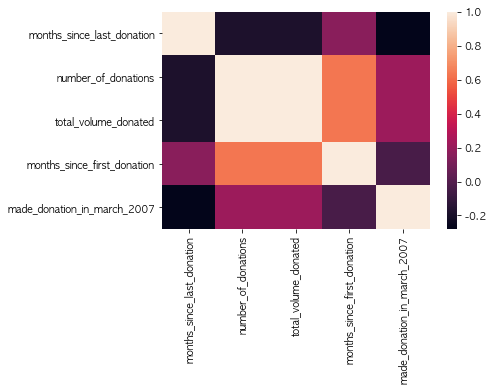

In [ ]:
sns.heatmap(donors.corr())

Total_Volume_Donated와 

<AxesSubplot:xlabel='number_of_donations', ylabel='months_since_first_donation'>

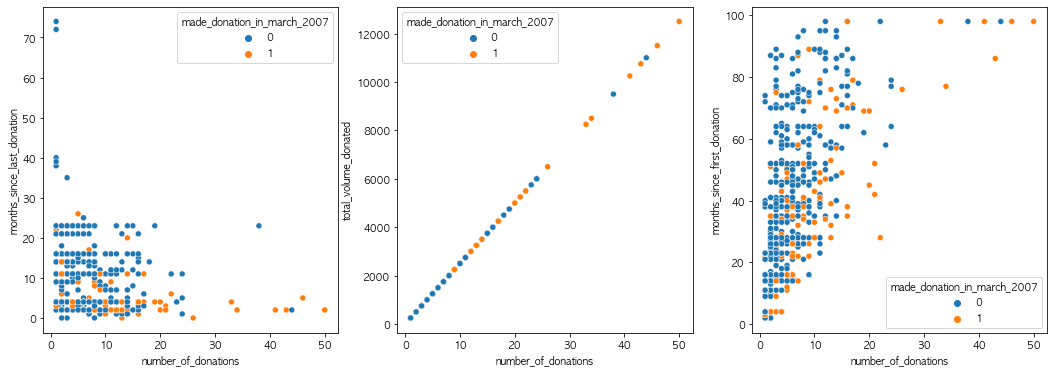

In [ ]:
fx,axes=plt.subplots(1,3, figsize=(18,6))
sns.scatterplot(ax=axes[0],data=donors, x='number_of_donations',y='months_since_last_donation',hue='made_donation_in_march_2007')
sns.scatterplot(ax=axes[1],data=donors, x='number_of_donations',y='total_volume_donated',hue='made_donation_in_march_2007')
sns.scatterplot(ax=axes[2],data=donors, x='number_of_donations',y='months_since_first_donation',hue='made_donation_in_march_2007')

<AxesSubplot:xlabel='months_since_last_donation', ylabel='months_since_first_donation'>

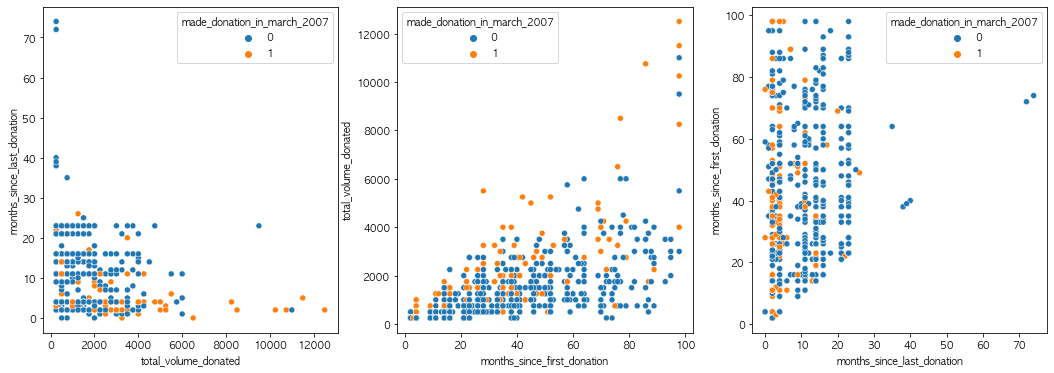

In [ ]:
fx,axes=plt.subplots(1,3, figsize=(18,6))
sns.scatterplot(ax=axes[0],data=donors, x='total_volume_donated',y='months_since_last_donation',hue='made_donation_in_march_2007')
sns.scatterplot(ax=axes[1],data=donors, x='months_since_first_donation',y='total_volume_donated',hue='made_donation_in_march_2007')
sns.scatterplot(ax=axes[2],data=donors, x='months_since_last_donation',y='months_since_first_donation',hue='made_donation_in_march_2007')

## 1.1 데이터를 feature (X), label(y)로 분할하고 데이터를 train/test 셋으로 무작위로 나누어 주세요 (scikit-learn 활용).

In [ ]:
# 이 곳에 답안을 작성하십시오
from sklearn.model_selection import train_test_split
train, test = train_test_split(donors, test_size = .2, random_state=2)

In [ ]:
target='made_donation_in_march_2007'
drops='total_volume_donated' #total_volume_donated는 number_of_donation과 상관계수 1으로 다중공선성 우려. 삭제
X_train = train.drop([target,drops],axis=1)
y_train = train[target]

X_test = test.drop([target,drops],axis=1)
y_test = test[target]
X_train

,months_since_last_donation,number_of_donations,months_since_first_donation
456,21,1,21
231,4,1,4
250,11,2,11
16,2,14,48
490,16,2,70
...,...,...,...
534,2,6,26
584,2,1,2
493,23,3,89
527,2,15,64


## 1.2 scikit-learn으로 logistic regression 모델을 만든 후에 학습 (fit)까지 진행하세요. 
> 학습에 사용할 feature 수는 자유롭게 결정 하십시오. 

In [ ]:
# 이 곳에 답안을 작성하십시오
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score

In [ ]:
# w={0:0.24, 1:0.76}
w={0.76,0.24}
logstic=LogisticRegression(random_state=2,class_weight=w)
logstic.fit(X_train,y_train)
y_pred=logstic.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.76
Confusion Matrix: 
[[111   3]
 [ 33   3]]
Area Under Curve: 0.5285087719298246
Recall score: 0.08333333333333333


Grid Search를 통하여 최적의 weight 값을 찾아봅니다.  


In [ ]:
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
hyperparam_grid = {"class_weight": w }
grid_logistic=LogisticRegression(random_state=2)
# define evaluation procedure
grid = GridSearchCV(grid_logistic , hyperparam_grid , scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
grid.fit(X_train,y_train)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.773 with param: {'class_weight': {0: 1.0, 1: 0.005}}


In [ ]:
weight={0:1, 1:0.005}
# weight={0:570, 1:178}
# 
logistic_param_tuned=LogisticRegression(random_state=2, class_weight=weight)
logistic_param_tuned.fit(X_train,y_train)
y_pred=logistic_param_tuned.predict(X_test)

print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.76
Confusion Matrix: 
[[114   0]
 [ 36   0]]
Area Under Curve: 0.5
Recall score: 0.0


최적의 weight값을 찾아서 적용시켜보았습니다.  
그런데, confusion matrix에 음성으로 판단하는 것이 없습니다.  
이러한 회귀모델은 매우 위험하다고 생각합니다.  
들어오는 input에 대해 그냥 1로 양성으로 찍어버리는것과 비슷할 수 있다고 생각하기에 , 적용했던 weight를 폐기하고,  
원래 적용했던 w = {0:0.76 , 1:0.24} 를 사용합니다.

In [ ]:
# w={0:0.24, 1:0.76}
w={0.76,0.24}
logstic=LogisticRegression(random_state=2,class_weight=w)
logstic.fit(X_train,y_train)
y_pred=logstic.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.76
Confusion Matrix: 
[[111   3]
 [ 33   3]]
Area Under Curve: 0.5285087719298246
Recall score: 0.08333333333333333


In [ ]:
# w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
#      {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
#      {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
#      {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
#      {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
#      {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
#      {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
#      {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
#      {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
#      {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
# crange = np.arange(0.5, 20.0, 0.5)
# hyperparam_grid = {"class_weight": w
#                    ,"penalty": ["l1", "l2"]
#                    ,"C": crange
#                    ,"fit_intercept": [True, False]  }

# lg4 = LogisticRegression(random_state=13)
# # define evaluation procedure
# grid = GridSearchCV(lg4,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
# grid.fit(X_train,y_train)
# print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

## 1.3 분류 평가 지표 (classification metric) 보고: 정확도 (accuracy)
> 테스트셋을 사용했을 때 분류 모델의 정확도(accuracy score)를 알려주세요.

모델의 성능이 베이스라인보다 안좋더라도 걱정하지 마세요. 
(accuracy 대신 recall을 평가 지표 (metric)로 사용할 경우에 우리가 만든 모델이 베이스라인을 뛰어넘을 수 있습니다. 알맞은 평가 지표를 고르고 해석하는 법은 앞으로 계속 다룰 예정입니다.)

In [ ]:

print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.76
Confusion Matrix: 
[[111   3]
 [ 33   3]]
Area Under Curve: 0.5285087719298246
Recall score: 0.08333333333333333


Accuracy Score : 0.76 이고, 
Confusion Matrix 는 위와 같습니다.  
111는 True Positive 로 실제 1인데 1로 예측한것이며,  
33은 False Positive 로 실제 0인데 1로 예측한것 (틀림)  
각각의 3은 False Negative (1,2)  True Negative (2,2)입니다.   
최종 accuracy는 $(111+3) \over (111+3+33+3)$ 으로 0.76 입니다.

In [ ]:
# 이 곳에 답안을 작성하십시오

# Part 2 - 회귀(Regression): Iowa 주 Ames의 집값 예측하기 🏠

여러분이 다루게 될 데이터는 Iowa 주에 있는 Ames시의 주택들의 정보를 모은 데이터셋입니다.

## 칼럼 설명


In [ ]:
# 데이터셋을 불러옵니다
import pandas as pd
homes = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/ames_home/ames_home_subset.csv')
assert homes.shape == (2904, 47)
target = 'SalePrice'

In [ ]:
homes.info()
homes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2904 entries, 0 to 2903
Data columns (total 47 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       2904 non-null   int64  
 1   BedroomAbvGr   2904 non-null   int64  
 2   BldgType       2904 non-null   object 
 3   BsmtFullBath   2904 non-null   float64
 4   BsmtHalfBath   2904 non-null   float64
 5   CentralAir     2904 non-null   object 
 6   Condition1     2904 non-null   object 
 7   Condition2     2904 non-null   object 
 8   Electrical     2904 non-null   object 
 9   ExterCond      2904 non-null   object 
 10  ExterQual      2904 non-null   object 
 11  Exterior1st    2904 non-null   object 
 12  Exterior2nd    2904 non-null   object 
 13  Foundation     2904 non-null   object 
 14  FullBath       2904 non-null   int64  
 15  Functional     2904 non-null   object 
 16  GrLivArea      2904 non-null   int64  
 17  HalfBath       2904 non-null   int64  
 18  Heating 

,1stFlrSF,BedroomAbvGr,BldgType,BsmtFullBath,BsmtHalfBath,CentralAir,Condition1,Condition2,Electrical,ExterCond,ExterQual,Exterior1st,Exterior2nd,Foundation,FullBath,Functional,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotShape,MSSubClass,MSZoning,MasVnrType,MoSold,Neighborhood,OverallCond,OverallQual,PavedDrive,RoofMatl,RoofStyle,SalePrice,SaleCondition,SaleType,Street,TotRmsAbvGrd,Utilities,YearBuilt,YearRemod/Add,YrSold
0,1656,3,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,BrkFace,Plywood,CBlock,1,Typ,1656,0,GasA,Fa,1Story,1,TA,Lvl,Gtl,31770,Corner,IR1,20,RL,Stone,5,NAmes,5,6,P,CompShg,Hip,215000,Normal,WD,Pave,7,AllPub,1960,1960,2010
1,896,2,1Fam,0.0,0.0,Y,Feedr,Norm,SBrkr,TA,TA,VinylSd,VinylSd,CBlock,1,Typ,896,0,GasA,TA,1Story,1,TA,Lvl,Gtl,11622,Inside,Reg,20,RH,None,6,NAmes,6,5,Y,CompShg,Gable,105000,Normal,WD,Pave,5,AllPub,1961,1961,2010
2,1329,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,Wd Sdng,Wd Sdng,CBlock,1,Typ,1329,1,GasA,TA,1Story,1,Gd,Lvl,Gtl,14267,Corner,IR1,20,RL,BrkFace,6,NAmes,6,6,Y,CompShg,Hip,172000,Normal,WD,Pave,6,AllPub,1958,1958,2010
3,2110,3,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,Gd,BrkFace,BrkFace,CBlock,2,Typ,2110,1,GasA,Ex,1Story,1,Ex,Lvl,Gtl,11160,Corner,Reg,20,RL,None,4,NAmes,5,7,Y,CompShg,Hip,244000,Normal,WD,Pave,8,AllPub,1968,1968,2010
4,928,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,VinylSd,VinylSd,PConc,2,Typ,1629,1,GasA,Gd,2Story,1,TA,Lvl,Gtl,13830,Inside,IR1,60,RL,None,3,Gilbert,5,5,Y,CompShg,Gable,189900,Normal,WD,Pave,6,AllPub,1997,1998,2010


In [ ]:
from pandas_profiling import ProfileReport
homes.profile_report()

## 2.1 Baseline 평가지표를 계산하세요

평균 baseline의 $MAE$ (Mean Absolute Error)와 $R^2$ 점수를 계산하세요 (계산을 하는 방법은 데이터를 나누지 않은 채로 계산하면 됩니다.) 

In [ ]:
# 이 곳에 답안을 작성하십시오
# target
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

home_price_mean=homes[target].mean()
print('MSE : ',sum((homes[target]-home_price_mean)**2))
print('R_Square : ',r2_score(homes[target] , homes['YearBuilt']))


MSE :  18487728408863.492
R_Square :  -4.999508080739364


## 2.2 데이터셋을 아래의 기준을 사용해서 train/validation/test 셋으로 나누세요

- **Train**: 2006년부터 2008년까지 팔린 주택들 (1,920개)

- **Validation**: 2009년에 팔린 주택들. (644개)

- **Test**: 2010년에 팔린 주택들. (340개)

In [ ]:
# 이 곳에 답안을 작성하십시오
# 건축년도 이후, 리모델링년도를 뺌으로써 이 값이 양수이면 00년 뒤에 리모델링되었다는 뜻
homes['AfterRemod']=homes['YearRemod/Add']-homes.YearBuilt

train = homes.query("YrSold >= 2006 and YrSold <= 2008")
val = homes.query("YrSold == 2009")
test = homes.query("YrSold == 2010")
train.shape, val.shape, test.shape

((1920, 48), (644, 48), (340, 48))

## 2.3 train / validation / test 셋을 features(X)와 target(y)으로 각각 나누세요

> 특성에는 최소 하나의 수치형 (numeric) 특성과 범주형 (categorical) 특성을 포함하세요.  
위의 조건을 만족한다면 추가 feature를 선택하는 것에 대한 제한은 없습니다.

In [ ]:
target = 'SalePrice'
categoricals=['MSZoning','Condition1','Condition2']
numericals=['1stFlrSF','GrLivArea','LotArea','OverallQual','OverallCond','YearBuilt','AfterRemod', 'FullBath']
features=categoricals + numericals

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [ ]:
X_train

,MSZoning,Condition1,Condition2,1stFlrSF,GrLivArea,LotArea,OverallQual,OverallCond,YearBuilt,AfterRemod,FullBath
984,RL,Norm,Norm,1414,1414,11029,6,8,1958,44,1
985,RL,Norm,Norm,2117,2117,12925,6,7,1970,0,2
986,RL,Norm,Norm,1092,2112,11075,6,5,1969,0,2
987,RL,Norm,Norm,926,1604,8702,6,5,1997,1,2
988,RL,Norm,Norm,680,1470,8139,6,5,1995,1,2
...,...,...,...,...,...,...,...,...,...,...,...
2899,RL,Norm,Norm,1003,1003,7937,6,6,1984,0,1
2900,RL,Norm,Norm,902,902,8885,5,5,1983,0,1
2901,RL,Norm,Norm,970,970,10441,5,5,1992,0,1
2902,RL,Norm,Norm,1389,1389,10010,5,5,1974,1,1


## 2.4 One-hot encoding을 카테고리형 특성(feature)에 수행하세요

In [ ]:
from category_encoders import OneHotEncoder
encoder = OneHotEncoder(use_cat_names = True) # 카테고리이름을 살려서
X_train_oh = encoder.fit_transform(X_train) # fit & transform을 시켜주었습니다.
X_val_oh = encoder.transform(X_val)
X_test_oh = encoder.transform(X_test)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
# 이 곳에 답안을 작성하십시오
X_train_oh

,MSZoning_RL,MSZoning_RH,MSZoning_RM,MSZoning_FV,MSZoning_A (agr),MSZoning_C (all),MSZoning_I (all),Condition1_Norm,Condition1_Feedr,Condition1_PosN,Condition1_RRAn,Condition1_RRAe,Condition1_RRNe,Condition1_Artery,Condition1_PosA,Condition1_RRNn,Condition2_Norm,Condition2_PosN,Condition2_Artery,Condition2_Feedr,Condition2_PosA,Condition2_RRNn,Condition2_RRAe,Condition2_RRAn,1stFlrSF,GrLivArea,LotArea,OverallQual,OverallCond,YearBuilt,AfterRemod,FullBath
984,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1414,1414,11029,6,8,1958,44,1
985,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2117,2117,12925,6,7,1970,0,2
986,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1092,2112,11075,6,5,1969,0,2
987,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,926,1604,8702,6,5,1997,1,2
988,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,680,1470,8139,6,5,1995,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1003,1003,7937,6,6,1984,0,1
2900,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,902,902,8885,5,5,1983,0,1
2901,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,970,970,10441,5,5,1992,0,1
2902,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1389,1389,10010,5,5,1974,1,1


기존의 11개였던 columns 가 32개로 늘어났습니다.

SelectKBest

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
# Instance 생성
selector = SelectKBest(score_func=f_regression, k=20)

# train 적용
X_train_K = selector.fit_transform(X_train_oh, y_train)

# test 적용
X_test_K = selector.transform(X_test_oh)
X_val_K = selector.transform(X_val_oh)

# 결과
print(X_train_K.shape, X_test_K.shape)

(1920, 20) (340, 20)


In [ ]:
all_names = X_train_oh.columns 

# selector.get_support()
selected_mask = selector.get_support()

# 선택된 특성들
selected_names = all_names[selected_mask]

# 선택되지 않은 특성들
unselected_names = all_names[~selected_mask] 

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['MSZoning_RL', 'MSZoning_RM', 'MSZoning_FV', 'MSZoning_C (all)',
       'Condition1_Norm', 'Condition1_Feedr', 'Condition1_PosN',
       'Condition1_RRAe', 'Condition1_Artery', 'Condition1_PosA',
       'Condition2_PosN', 'Condition2_PosA', '1stFlrSF', 'GrLivArea',
       'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'AfterRemod',
       'FullBath'],
      dtype='object')
Unselected names:  Index(['MSZoning_RH', 'MSZoning_A (agr)', 'MSZoning_I (all)',
       'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn',
       'Condition2_Norm', 'Condition2_Artery', 'Condition2_Feedr',
       'Condition2_RRNn', 'Condition2_RRAe', 'Condition2_RRAn'],
      dtype='object')


## 2.5 scikit-learn으로 linear regression이나 ridge regression 모델을 만들어서 학습하세요

In [ ]:
# 이 곳에 답안을 작성하십시오
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
poly_features = PolynomialFeatures(degree=3)
X_poly_train = poly_features.fit_transform(X_train_K)
X_poly_test = poly_features.transform(X_test_K)

ridge_cv = RidgeCV(normalize=True,cv = 5)
ridge_cv.fit(X_poly_train,y_train)

print('Best lambda : {:.3f}'.format(ridge_cv.alpha_))

Best lambda : 1.000


## 2.6 Validation 데이터셋의 MAE and $R^2$
> validation 데이터셋에 모델을 예측했을 때의 MAE와 $R^2$ 점수를 계산하세요. (검증 점수의 높고 낮음은 채점에 영향을 미치지 않습니다)

In [ ]:
# 이 곳에 답안을 작성하십시오

In [ ]:
from sklearn.linear_model import Ridge

poly_features = PolynomialFeatures(degree=3)
X_poly_train = poly_features.fit_transform(X_train_K)
X_poly_test = poly_features.fit_transform(X_test_K)
ridge = Ridge(alpha=1)
ridge.fit(X_poly_train,y_train)
y_test_pred = ridge.predict(X_poly_test)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

In [ ]:
print("MSE : " ,mse)
print("MAE : ",mae) 
print('R2 : ',r2)

MSE :  3.112594232465059e+16
MAE :  19145064.001508195
R2 :  -5593999.614813556


# Advanced Goals: 3점을 획득하기 위해선 아래의 모든 조건을 만족해야합니다. 
### Part 2의 데이터셋을 활용하여 아래의 과제들을 수행하세요.
- 다양한 시각화 라이브러리를 활용하여 feature와 target의 관계를 보여주는 시각화를 최소 2개 이상 하세요. 
- 최소 3개 이상의 feature 조합을 시도해보세요. feature의 조합을 고르는 방법에는 어떠한 제한도 없습니다.
- 위에서 시도한 각 feature 조합에 대한 validation set의 MAE & $R^2$를 계산하세요.
- 최종 모델을 정한 후 test set의 MAE and $R^2$을 계산하세요.
- 최종 모델에서 사용한 특성들의 회귀 계수 (coefficients)를 출력하거나 시각화 하세요.

# 이 곳에 답안을 작성하십시오